In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.display
import numpy as np

from src.data import NSynthDataset

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, h_dim=512):
        super(Autoencoder, self).__init__()
        
        # (1, 40, 126)
        self.conv1 = nn.Conv2d(1, 64, 4, padding=1, stride=(2, 2))
        self.conv2 = nn.Conv2d(64, 128, 4, padding=1, stride=(2, 2))
        self.conv3 = nn.Conv2d(128, 256, 4, padding=1, stride=(2, 2))
        self.conv4 = nn.Conv2d(256, 512, 4, padding=1, stride=(2, 2))
        
        self.fc_enc = nn.Linear(7168, h_dim, bias=True)
        self.fc_dec = nn.Linear(h_dim, 7168, bias=True)

        self.deconv1 = nn.ConvTranspose2d(512, 256, 3, stride=2)
        self.deconv2 = nn.ConvTranspose2d(256, 128, (2, 3), stride=2)
        self.deconv3 = nn.ConvTranspose2d(128, 64, (2, 3), stride=2)
        self.deconv4 = nn.ConvTranspose2d(64, 1, 2, stride=2)
        
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
    
        x = x.view(x.size(0), -1)
        return F.relu(self.fc_enc(x))
        
    def decode(self, z):
        h = F.relu(self.fc_dec(z))
        h = h.view(h.size(0), 512, 2, 7)
        
        h = F.relu(self.deconv1(h))
        h = F.relu(self.deconv2(h))
        h = F.relu(self.deconv3(h))
        h = self.deconv4(h)
        return torch.sigmoid(h)
        
    def forward(self, x):
        z = self.encode(x)
        outputs = self.decode(z)
        return outputs

In [3]:
hparams = {
    'feature_type' : 'mfcc',
    'instrument_source' : [0],
    'scaling' : 'normalize',
    'n_epochs' : 25,
    'batch_size' : 32,
    'lr' : 0.001,
    'hidden_dim' : 512,
    'display_iters' : 10,
    'val_iters' : 100,
    'n_val_samples' : 1000
}

In [4]:
train_dataset = NSynthDataset(
    'music-ml-gigioli', 
    'data/nsynth/nsynth-train', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling']
)

val_dataset = NSynthDataset(
    'music-ml-gigioli', 
    'data/nsynth/nsynth-valid', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling']
)

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

In [6]:
model = Autoencoder(h_dim=hparams['hidden_dim'])

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

[0,    10] loss : 0.2942
[0,    20] loss : 0.2687
[0,    30] loss : 0.3046
[0,    40] loss : 0.3135
[0,    50] loss : 0.3089
[0,    60] loss : 0.3063
[0,    70] loss : 0.3149
[0,    80] loss : 0.2744
[0,    90] loss : 0.3101
[0,   100] loss : 0.3056
Val - loss : 0.2993
[0,   110] loss : 0.2805
[0,   120] loss : 0.3061
[0,   130] loss : 0.2986
[0,   140] loss : 0.3407
[0,   150] loss : 0.2653
[0,   160] loss : 0.2782
[0,   170] loss : 0.2944
[0,   180] loss : 0.2888
[0,   190] loss : 0.2821
[0,   200] loss : 0.2780
Val - loss : 0.2812
[0,   210] loss : 0.2821
[0,   220] loss : 0.2650
[0,   230] loss : 0.2734
[0,   240] loss : 0.2751
[0,   250] loss : 0.2839
[0,   260] loss : 0.2399
[0,   270] loss : 0.2829
[0,   280] loss : 0.2494
[0,   290] loss : 0.2479
[0,   300] loss : 0.2847
Val - loss : 0.2671
[0,   310] loss : 0.2924
[0,   320] loss : 0.2627
[0,   330] loss : 0.3075
[0,   340] loss : 0.2805
[0,   350] loss : 0.3047
[0,   360] loss : 0.2814
[0,   370] loss : 0.2825
[0,   380] loss

KeyboardInterrupt: 

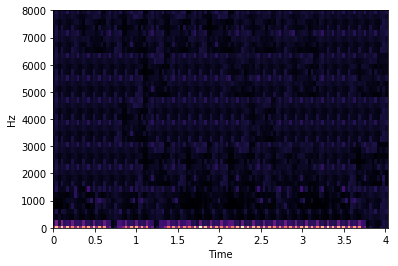

In [9]:
loss_fn = nn.BCELoss()

for epoch in range(hparams['n_epochs']):
    itr = 0
    for batch in train_dataloader:
        itr += 1
        batch = batch.unsqueeze(1)
        outputs = model(batch)
        
        loss = loss_fn(outputs, batch)
        loss.backward()
        optimizer.step()
        
        if itr % hparams['display_iters'] == 0:
            print('[{}, {:5d}] loss : {:.4f}'.format(epoch, itr, loss.item()))
            
        if itr % hparams['val_iters'] == 0:
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)
            
            model.eval()
            
            ct, i, val_loss = 0, 0, 0.0
            for batch in val_dataloader:
                i += 1
                ct += batch.size(0)
                batch = batch.unsqueeze(1)
                outputs = model(batch)
                
                loss = loss_fn(outputs, batch)
                val_loss += (loss.item() - val_loss)/i
                
                if ct >= hparams['n_val_samples']:
                    break
            
            print('Val - loss : {:.4f}'.format(val_loss))
            librosa.display.specshow(batch[0][0].numpy(), sr=16000, x_axis='time', y_axis='hz')
            librosa.display.specshow(outputs[0][0].detach().numpy(), sr=16000, x_axis='time', y_axis='hz')
                    
            model.train()

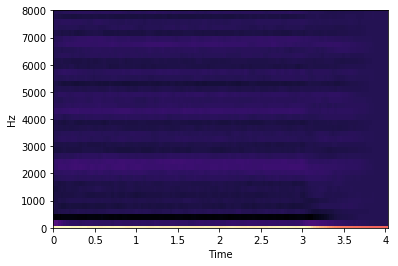

In [44]:
librosa.display.specshow(batch[0][0].numpy(), sr=16000, x_axis='time', y_axis='hz')

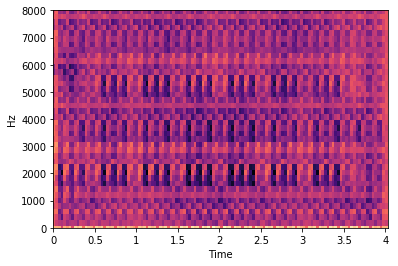

In [46]:
librosa.display.specshow(outputs[0][0].detach().numpy(), sr=16000, x_axis='time', y_axis='hz')

In [47]:
outputs[0][0]

tensor([[0.5025, 0.5035, 0.4984,  ..., 0.4103, 0.5081, 0.5098],
        [0.3896, 0.3400, 0.3142,  ..., 0.2949, 0.3577, 0.3409],
        [0.3912, 0.3639, 0.2629,  ..., 0.2216, 0.3824, 0.3868],
        ...,
        [0.3000, 0.3750, 0.2062,  ..., 0.2813, 0.3531, 0.3934],
        [0.3863, 0.3898, 0.3407,  ..., 0.3844, 0.3861, 0.3870],
        [0.3582, 0.4101, 0.2673,  ..., 0.3059, 0.3323, 0.3870]],
       grad_fn=<SelectBackward>)

In [48]:
batch[0][0]

tensor([[0.9732, 0.9944, 1.0000,  ..., 0.6722, 0.6722, 0.6722],
        [0.2727, 0.2514, 0.2207,  ..., 0.1469, 0.1469, 0.1469],
        [0.0245, 0.0078, 0.0141,  ..., 0.1469, 0.1469, 0.1469],
        ...,
        [0.1524, 0.1572, 0.1599,  ..., 0.1469, 0.1469, 0.1469],
        [0.1415, 0.1366, 0.1274,  ..., 0.1469, 0.1469, 0.1469],
        [0.1451, 0.1485, 0.1468,  ..., 0.1469, 0.1469, 0.1469]])

In [61]:
deploy_dataset = NSynthDataset(
    'music-ml-gigioli', 
    'data/nsynth/nsynth-train', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=None
)

In [62]:
deploy_dataloader = torch.utils.data.DataLoader(deploy_dataset, batch_size=1, shuffle=True)

In [63]:
for x in deploy_dataloader:
    break

In [64]:
x.size()

torch.Size([1, 40, 126])

In [49]:
import IPython.display

In [65]:
signal = librosa.feature.inverse.mfcc_to_audio(x[0].numpy(), n_mels=40)

In [66]:
signal.shape

(64000,)

In [67]:
IPython.display.Audio(signal, rate=16000)